# Advanced Realistic and Intelligent Assistants (mARIA)

In this notebook, we design an advanced, realistic and intelligent assistants for different purposes. Actually, chatbots perform only as good as we train them with the available datasets. We attempt to train our chatbot with the set of banking terms and conditions from different banks that is available from the internet. We prepare the relevant datasets from the given data and observe how it performs for a small dataset at first. We aim to improve the dataset, which improves the overall data training. 

In [1]:
import numpy as np
import nltk
import itertools
import sys
EN_WHITELIST = '0123456789abcdefghijklmnopqrstuvwxyz '
EN_BLACKLIST = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\''
limit = {
    'maxq': 25,
    'minq': 0,
    'maxa': 25,
    'mina': 3
}
UNK='unk' #unknowns
VOCAB_SIZE = 800

In [251]:
def read_lines(filename):
    return open(filename).read().split('\n')[:-1]

def split_lines(line):
    return line.split('.')

def filter_line(line, whitelist):
    return ''.join([ch for ch in line if ch in whitelist])

def filter_data(sequences):
    filtered_q = [] 
    filtered_a = []
    lines_len = len(sequences)//2
    
    for i in range(0, len(sequences), 2):
        qlen, alen = len(sequences[i].split(' ')), len(sequences[i + 1].split(' '))
        if qlen >= limit['minq'] and qlen <= limit['maxq']:
            if alen >= limit['mina'] and alen <= limit['maxa']:
                filtered_q.append(sequences[i])
                filtered_a.append(sequences[i + 1])
    filt_data_len = len(filtered_q)
    filtered = int((lines_len - filt_data_len) * 100 / lines_len)
    print(str(filtered) + '% filtered from original data')

    return filtered_q, filtered_a


def index_(tokenized_sentences, vocab_size):
    freq_dist = nltk.FreqDist(itertools.chain(*tokenized_sentences))
    # get vocabulary of 'vocab_size' most used words
    vocab = freq_dist.most_common(vocab_size)
    # index2word
    index2word = ['_'] + [UNK] + [x[0] for x in vocab]
    # word2index
    word2index = dict([(w, i) for i, w in enumerate(index2word)])
    return index2word, word2index, freq_dist 

def pad_seq(seq, lookup, maxlen):
    indices = []
    for word in seq:
        if word in lookup:
            indices.append(lookup[word])
        else:
            indices.append(lookup[UNK])
    return indices + [0] * (maxlen - len(seq))

def zero_pad(qtokenized, atokenized, w2idx):
    # num of rows
    data_len = len(qtokenized)

    # numpy arrays to store indices
    idx_q = np.zeros([data_len, limit['maxq']], dtype=np.int32)
    idx_a = np.zeros([data_len, limit['maxa']], dtype=np.int32)

    for i in range(data_len):
        q_indices = pad_seq(qtokenized[i], w2idx, limit['maxq'])
        a_indices = pad_seq(atokenized[i], w2idx, limit['maxa'])

        # print(len(idx_q[i]), len(q_indices))
        # print(len(idx_a[i]), len(a_indices))
        idx_q[i] = np.array(q_indices)
        idx_a[i] = np.array(a_indices)

    return idx_q, idx_a

    


In [252]:
filename='./data/banking_terms.txt'

In [253]:
data=read_lines(filename)
lines = [line.lower() for line in data]
lines_fil = [filter_line(line, EN_WHITELIST) for line in lines]
qlines, alines = filter_data(lines)

26% filtered from original data


In [254]:
qtokenized = [wordlist.split(' ') for wordlist in qlines]
atokenized = [wordlist.split(' ') for wordlist in alines]


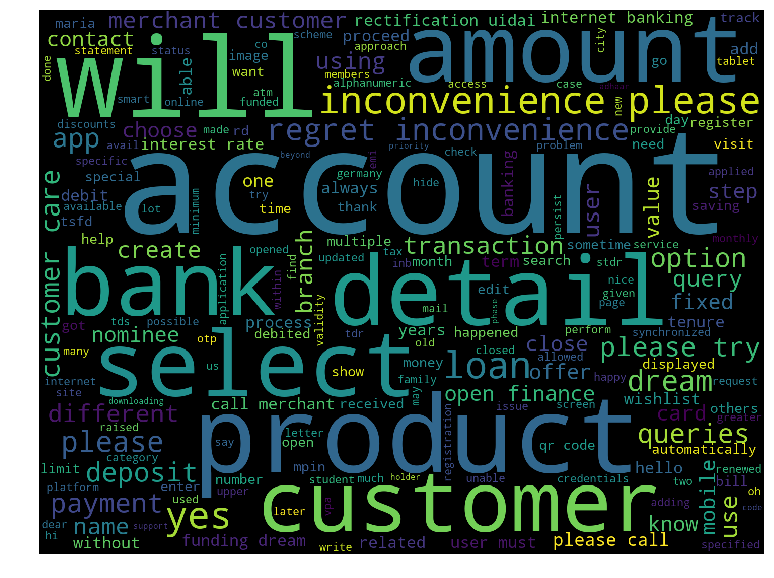

In [255]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
cloud = WordCloud(width=1440, height=1080).generate(" ".join(qlines+alines))
plt.figure(figsize=(15,10))
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [256]:
idx2w, w2idx, freq_dist = index_(qtokenized + atokenized, vocab_size=VOCAB_SIZE)

In [257]:
idx_q, idx_a = zero_pad(qtokenized, atokenized, w2idx)

In [258]:
idx_q[65]

array([ 28, 163,   2,  81,  32, 585,  75,  19, 156, 610,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [259]:
 print('\n >> Save numpy arrays to disk')
    # save them
np.save('idx_q.npy', idx_q)
np.save('idx_a.npy', idx_a)


 >> Save numpy arrays to disk


In [260]:
import pickle
# let us now save the necessary dictionaries
metadata = {
        'w2idx': w2idx,
        'idx2w': idx2w,
        'limit': limit,
        'freq_dist': freq_dist
    }

# write to disk : data control dictionaries
with open('metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
#print(metadata['limit'])

In [261]:
def load_data(PATH=''):
    # read data control dictionaries
    with open(PATH + 'metadata.pkl', 'rb') as f:
        metadata = pickle.load(f)
    # read numpy arrays
    idx_q = np.load(PATH + 'idx_q.npy')
    idx_a = np.load(PATH + 'idx_a.npy')
    return metadata, idx_q, idx_a

In [262]:
#load_data
metadata, idx_q,idx_a = load_data('')

In [263]:
len(metadata['w2idx'])

676

In [264]:
def split_dataset(x, y, ratio = [0.7, 0.15, 0.15] ):
    # number of examples
    data_len = len(x)
    lens = [ int(data_len*item) for item in ratio ]

    trainX, trainY = x[:lens[0]], y[:lens[0]]
    testX, testY = x[lens[0]:lens[0]+lens[1]], y[lens[0]:lens[0]+lens[1]]
    validX, validY = x[-lens[-1]:], y[-lens[-1]:]

    return (trainX,trainY), (testX,testY), (validX,validY)

In [265]:
(trainX, trainY), (testX, testY), (validX, validY) = split_dataset(idx_q, idx_a)
validX.shape

(13, 25)

In [266]:
xseq_len=trainX.shape[-1]
yseq_len=trainY.shape[-1]
batch_size = 32

In [267]:
xvocab_size=len(metadata['idx2w'])
yvocab_size = xvocab_size
embed_dim = 1024
print(xvocab_size)

676


In [268]:
#print(xvocab_size)

In [236]:
class Seq2Seq(object):
    def __init__(self, xseq_len, yseq_len,
                 xvocab_size, yvocab_size,
                 emb_dim, num_layers, ckpt_path,
                 lr=0.0001,
                 epochs=100000, model_name='seq2seq_model'):

        # attach these arguments to self
        self.xseq_len = xseq_len
        self.yseq_len = yseq_len
        self.ckpt_path = ckpt_path
        self.epochs = epochs
        self.model_name = model_name

        # build the graph
        #  attach any part of the graph that needs to be exposed, to the self
        def __graph__():
            # placeholders
            tf.reset_default_graph()
            #  encoder inputs : list of indices of length xseq_len
            self.enc_ip = [tf.placeholder(shape=[None, ],
                                          dtype=tf.int64,
                                          name='ei_{}'.format(t)) for t in range(xseq_len)]

            #  labels that represent the real outputs
            self.labels = [tf.placeholder(shape=[None, ],
                                          dtype=tf.int64,
                                          name='ei_{}'.format(t)) for t in range(yseq_len)]

            #  decoder inputs : 'GO' + [ y1, y2, ... y_t-1 ]
            self.dec_ip = [tf.zeros_like(self.enc_ip[0], dtype=tf.int64, name='GO')] + self.labels[:-1]

            # Basic LSTM cell wrapped in Dropout Wrapper
            self.keep_prob = tf.placeholder(tf.float32)
            # define the basic cell
            basic_cell = tf.contrib.rnn.DropoutWrapper(
                tf.contrib.rnn.BasicLSTMCell(emb_dim, state_is_tuple=True),
                output_keep_prob=self.keep_prob)
            # stack cells together : n layered model
            stacked_lstm = tf.contrib.rnn.MultiRNNCell([basic_cell] * num_layers, state_is_tuple=True)

            # for parameter sharing between training model
            #  and testing model
            with tf.variable_scope('decoder') as scope:
                # build the seq2seq model
                #  inputs : encoder, decoder inputs, LSTM cell type, vocabulary sizes, embedding dimensions
                self.decode_outputs, self.decode_states = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(self.enc_ip,
                                                                                                          self.dec_ip,
                                                                                                          stacked_lstm,                                                                                           xvocab_size,
                                                                                                          yvocab_size,
                                                                                                          emb_dim)
                # share parameters
                scope.reuse_variables()
                # testing model, where output of previous timestep is fed as input
                #  to the next timestep
                self.decode_outputs_test, self.decode_states_test = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(
                    self.enc_ip, self.dec_ip, stacked_lstm, xvocab_size, yvocab_size, emb_dim,
                    feed_previous=True)

            # now, for training,
            #  build loss function

            # weighted loss
            #  TODO : add parameter hint
            loss_weights = [tf.ones_like(label, dtype=tf.float32) for label in self.labels]
            self.loss = tf.contrib.legacy_seq2seq.sequence_loss(self.decode_outputs, self.labels, loss_weights,
                                                                yvocab_size)
            # train op to minimize the loss
            self.train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(self.loss)

        sys.stdout.write('<log> Building Graph ')
        # build comput graph
        __graph__()
        sys.stdout.write('</log>')

    '''
        Training and Evaluation

    '''

    # get the feed dictionary
    def get_feed(self, X, Y, keep_prob):
        feed_dict = {self.enc_ip[t]: X[t] for t in range(self.xseq_len)}
        feed_dict.update({self.labels[t]: Y[t] for t in range(self.yseq_len)})
        feed_dict[self.keep_prob] = keep_prob  # dropout prob
        return feed_dict

    # run one batch for training
    def train_batch(self, sess, train_batch_gen):
        # get batches
        batchX, batchY = train_batch_gen.__next__()
        # build feed
        feed_dict = self.get_feed(batchX, batchY, keep_prob=0.5)
        _, loss_v = sess.run([self.train_op, self.loss], feed_dict)
        return loss_v

    def eval_step(self, sess, eval_batch_gen):
        # get batches
        batchX, batchY = eval_batch_gen.__next__()
        # build feed
        feed_dict = self.get_feed(batchX, batchY, keep_prob=1.)
        loss_v, dec_op_v = sess.run([self.loss, self.decode_outputs_test], feed_dict)
        # dec_op_v is a list; also need to transpose 0,1 indices
        #  (interchange batch_size and timesteps dimensions
        dec_op_v = np.array(dec_op_v).transpose([1, 0, 2])
        return loss_v, dec_op_v, batchX, batchY

    # evaluate 'num_batches' batches
    def eval_batches(self, sess, eval_batch_gen, num_batches):
        losses = []
        for i in range(num_batches):
            loss_v, dec_op_v, batchX, batchY = self.eval_step(sess, eval_batch_gen)
            losses.append(loss_v)
        return np.mean(losses)

    # finally the train function that
    # runs the train_op in a session
    # evaluates on valid set periodically
    # prints statistics
    def train(self, train_set, valid_set, sess=None):

        # we need to save the model periodically
        saver = tf.train.Saver()

        # if no session is given
        if sess is None:
            print("No session\n")
            # create a session
            sess = tf.Session()
            # init all variables
            sess.run(tf.global_variables_initializer())
        else:
            print("I have a session\n")

        sys.stdout.write('\n<log> Training started </log>\n')
        # run M epochs
        for i in range(self.epochs):
            print("Current i: "+str(i))
            try:
                self.train_batch(sess, train_set)
                if i and i % (self.epochs // 1000) == 0:  # TODO : make this tunable by the user
                    # save model to disk
                    saver.save(sess, self.ckpt_path + self.model_name + '.ckpt', global_step=i)
                    # evaluate to get validation loss
                    val_loss = self.eval_batches(sess, valid_set, 32)  # TODO : and this
                    # print stats
                    print('\nModel saved to disk at iteration #{}'.format(i))
                    print('val   loss : {0:.6f}'.format(val_loss))
                    sys.stdout.flush()
            except KeyboardInterrupt:  # this will most definitely happen, so handle it
                print('Interrupted by user at iteration {}'.format(i))
                self.session = sess
                return sess



    def restore_last_session(self):
        saver = tf.train.Saver()
            # create a session
        sess = tf.Session()
            # get checkpoint state
        ckpt = tf.train.get_checkpoint_state(self.ckpt_path)
            # restore session
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
                # return to user
            return sess


    # prediction
    def predict(self, sess, X):
        feed_dict = {self.enc_ip[t]: X[t] for t in range(self.xseq_len)}
        feed_dict[self.keep_prob] = 1.
        dec_op_v = sess.run(self.decode_outputs_test, feed_dict)
        # dec_op_v is a list; also need to transpose 0,1 indices
        #  (interchange batch_size and timesteps dimensions
        dec_op_v = np.array(dec_op_v).transpose([1, 0, 2])
        # return the index of item with highest probability
        return np.argmax(dec_op_v, axis=2)


In [237]:
import tensorflow as tf
model =Seq2Seq(xseq_len=xseq_len,yseq_len=yseq_len,xvocab_size=xvocab_size,yvocab_size=yvocab_size,
               ckpt_path='checkpoint/',emb_dim=embed_dim,num_layers=3)

<log> Building Graph </log>

In [238]:
from random import sample
def rand_batch_gen(x, y, batch_size):
    while True:
        sample_idx = sample(list(np.arange(len(x))), batch_size)
        yield x[sample_idx].T, y[sample_idx].T


In [239]:
valid_batch_gen = rand_batch_gen(validX, validY, 10)
train_batch_gen = rand_batch_gen(trainX, trainY, batch_size)

In [244]:
sessi = model.restore_last_session()
sessi = model.train(train_batch_gen, valid_batch_gen,sessi)

No session


<log> Training started </log>
Current i: 0
Current i: 1
Current i: 2
Current i: 3
Current i: 4
Current i: 5
Current i: 6
Current i: 7
Current i: 8
Current i: 9
Current i: 10
Current i: 11
Current i: 12
Current i: 13
Current i: 14
Current i: 15
Current i: 16
Current i: 17
Current i: 18
Current i: 19
Current i: 20
Current i: 21
Current i: 22
Current i: 23
Current i: 24
Current i: 25
Current i: 26
Current i: 27
Current i: 28
Current i: 29
Current i: 30
Current i: 31
Current i: 32
Current i: 33
Current i: 34
Current i: 35
Current i: 36
Current i: 37
Current i: 38
Current i: 39
Current i: 40
Current i: 41
Current i: 42
Current i: 43
Current i: 44
Current i: 45
Current i: 46
Current i: 47
Current i: 48
Current i: 49
Current i: 50
Current i: 51
Current i: 52
Current i: 53
Current i: 54
Current i: 55
Current i: 56
Current i: 57
Current i: 58
Current i: 59
Current i: 60
Current i: 61
Current i: 62
Current i: 63
Current i: 64
Current i: 65
Current i: 66
Current i: 67
Current i: 68
C

Current i: 531
Current i: 532
Current i: 533
Current i: 534
Current i: 535
Current i: 536
Current i: 537
Current i: 538
Interrupted by user at iteration 538


In [245]:
test_batch_gen = rand_batch_gen(testX, testY,12)


In [246]:
sess = model.restore_last_session()

input_ = test_batch_gen.__next__()[0]
output = model.predict(sess, input_)
print(output.shape)

(12, 25)


In [247]:
output_file = open("testtraining.txt", 'a')

In [248]:
def decode(sequence, lookup, separator=''): # 0 used for padding, is ignored
    return separator.join([ lookup[element] for element in sequence if element ])

'''
 encode function
    inputs : sentence, lookup
'''
def encode(sentence, lookup, maxlen, whitelist=EN_WHITELIST, separator=''):
    # to lower case
    sentence = sentence.lower()
    # allow only characters that are on whitelist
    sentence = ''.join( [ ch for ch in sentence if ch in whitelist ] )
    # words to indices
    indices_x = [ token for token in sentence.strip().split(' ') ]
    # clip the sentence to fit model (#words)
    indices_x = indices_x[-maxlen:] if len(indices_x) > maxlen else indices_x
    # zero pad
    idx_x = np.array(pad_seq(indices_x, lookup, maxlen))
    # reshape
    return idx_x.reshape([maxlen, 1])


In [249]:
replies = []
for ii, oi in zip(input_.T, output):
    q = decode(sequence=ii, lookup=metadata['idx2w'], separator=' ')
    decoded = decode(sequence=oi, lookup=metadata['idx2w'], separator=' ').split(' ')
    if decoded.count('unk') == 0:
        if decoded not in replies:
            line = 'q : [{0}]; a : [{1}]'.format(q, ' '.join(decoded))
            print(line)
            output_file.write(str(line)+"\n")
            replies.append(decoded)

q : [my bank account got debited twice. whom do i contact?]; a : [ok sure. i i that that that]
q : [customer raised the query but don't track id ]; a : [we regret is the the the the the the the the the the the ]
q : [is it possible to access my account from here?]; a : [interest rate is is that for the the the the the the]
q : [cashback as displayed not received.]; a : [please regret the inconvenience. please option]
q : [customer raised the query but don’t know what happened next]; a : [we regret the inconvenience. the the the the the the the the]
q : [i am not able to upload my image.]; a : [please visit your your nearest to to open account]
q : [my account got debited, merchant claims non-receipt of money.]; a : [no. letter is check that that the let you the the the]
q : [my occupation is not given in the list. what should i do?]; a : [we regret the inconvenience. please the the the customer customer any queries queries queries product.]
q : [i am unable to add products to my wishli

In [205]:
len(validX)

12

In [206]:
def FilteredMessage(EntryText):
    """
    Filter out all useless white lines at the end of a string,
    returns a new, beautifully filtered string.
    """
    EndFiltered = ''
    for i in range(len(EntryText) - 1, -1, -1):
        if EntryText[i] != '\n':
            EndFiltered = EntryText[0:i + 1]
            break
    for i in range(0, len(EndFiltered), 1):
        if EndFiltered[i] != "\n":
            return EndFiltered[i:] + '\n'
    return ''


sentence = "word Embeddings are the words converted into numbers" 
dictionary = list of all unique words in the sentence 
dictionary = [word, Embeddings, are, the, coverted, into, numbers ] 
The vector representation of each word can be a one-hot vector. It is also called unit vector, where the position for a word is represented by 1 and 0 elsewhere. 
vector representation of word is [1 0 0 0 0 0 0] and of into is [0 0 0 0 0 1 0 ] and so on . 
It is one of the simplest methods to represent words to numbers or vectors but not the most efficient one. Let us explore different types of word embeddings. 

Broadly, word embeddings are categorized as : Freqiency based embedding and predictive based embeddings.

Frequency based embeddings: 
1. Count vector
2. TF-IDF vector 
3. Co-occurrence vector

Count vector : 
Consider a corpus C, which contains D documents as: C = {d1, d2 , ... dD}. Let us extract N unique tokens from the corpus. Then these N tokens will form our dictionary. The count vector matrix will be of the size D by N. 
For example: d1 = 'what are the people doing today ? '
             d2 = 'I do not know what do these people do today'
             
             Create a dictionary of 'N' unique words. Here, we consider N = all the unique words but it does not need to be all the values. 
             
             dictionary = [what, are, the, people, today, I, do, not, know, these]
             
             The count matrix is constructed as D by N matrix. 
             
             what are the people today I do not know these
           d1 1    1    1   1      1   0  1  0    0    0
           d2 1    0    0   1      1   1  3  1    1    1
           
         Each column can be considered as the word vector corresponding to that particular word. E.g the word vector for what is [1,1] and for do is [1,3] and so on. However, there are limitations for such scheme, when the number of unique words are very large. 
         
TF-IDF Vectorization: Common words like - is, are, the, this etc. appear most frequently in all the documents in comparison to the words which are most important to a particular document. For example if we have a document that describes about university, the word 'university' occurs in that document more frequently than in the other documents. But other common words also occur most frequently in all documents. In that case we try to give low weights to the common words occurring in all the documents and higher significance to the common words in specific document. TF-IDF does exactly the same. 

TF = (Number of times any term appears in a document)/(Number of terms in the document)
In a document about university, there are 40 words in total and the word 'university' appears 5 times in the whole document; then the term frequence (TF) for the term 'university' is 5/40 = 1/8 = 0.125.
Similarly, the term 'is' occurs in the document 6 times and TF for 'is' = 6/40 = 3/20 = 0.15

There is the other document about 'football' (with 50 words), where the word university occurs 1 time but the word 'is' occurs 10 times.

TF for university (doc 2) = 1/50 = 0.02
TF for is (doc 2) = 10/50 = 0.2


IDF = log(N/n), where N = total number of document and n = No. of documents the term has appeared

Suppose there are total 5 documents and the word 'university' occurs in 2 documents only but the word 'is' occurs in all 5 documents then
IDF (university) =log(5/2) = 
IDF (is) = log (5/5) = 0

TF-IDF ('university', doc 1) = 0.125 * log(5/2) =
TF-IDF ('is', doc 1) = 0.15 * 0 = 0



Prediction based Embeddings : 

Earlier methods are deterministic and posses a lot of limitations. However, the prediction based method provides probabilities to the words. Word2Vec method is very common as of today to generate vectors from the words.

Word2vec is a combination of two techniques - Continuous bag of words (CBOW) and Skip-gram model. 

Continuous Bag of Words (CBOW): 
Consider the sentence "The cat jumped over the puddle". We treat {'the','cat', 'over', 'the', 'puddle'} as a context and be able to predict the word 'jumped' from this context. 



In [1]:
import sqlite3
import json
from datetime import datetime

In [2]:
timeframe = '2015-05'
sql_transaction = []
connection = sqlite3.connect('{}.db'.format(timeframe))
c= connection.cursor()

In [3]:
def create_table():
    c.execute("CREATE TABLE IF NOT EXISTS parent_reply(parent_id TEXT PRIMARY KEY,comment_id TEXT UNIQUE, parent TEXT,comment TEXT, subreddit TEXT, unix INT, score INT)")

In [5]:
if __name__=='__main__()':
    create_table()
    row_counter = 0
    paired_rows = 0


In [13]:
filename = 'DS_words.txt'
ds_words = open(filename).read().split(', ')[:-1]

In [14]:
ds_words

['Data science',
 'machine learning',
 'deep learning',
 'Cloud computing',
 'artificial intelligence',
 'Big data',
 'Internet of things',
 'Neural network',
 'Data visualization',
 'data preprocessing',
 'normalization',
 'standardization',
 'python',
 'R',
 'pandas',
 'scikit learn',
 'Regular expression',
 'Tensorflow',
 'RNN',
 'CNN',
 'LSTM',
 'prediction',
 'forecasting',
 'Real time streaming',
 'Matlab',
 'Linear Algebra',
 'Optimization',
 'Natural language processing,data deployment',
 'keras',
 'theano',
 'seaborn',
 'matplotlib',
 'scipy',
 'jupyter notebook',
 'Data dictionary',
 'data modelling',
 'statistical analysis',
 'apache spark',
 'hadoop',
 'mapreduce',
 'Exploratory data analysis',
 'kaggle',
 'datasets',
 'supervised learning',
 'binary classification',
 'multi-variable classification',
 'sparse data',
 'data imputation',
 'calculus',
 'linear regression',
 'polynomial regression',
 'unsupervised learning',
 'clustering',
 'Decision tree',
 'random forest',
 '

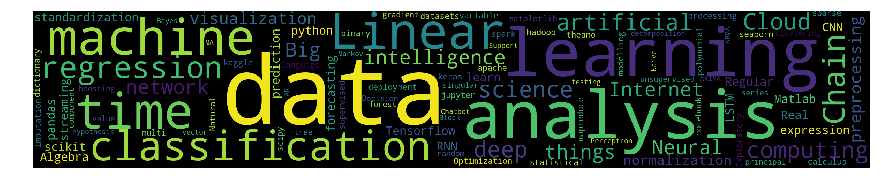

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
cloud = WordCloud(width=2400, height=450).generate(" ".join(ds_words))
plt.figure(figsize=(15,10))
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [16]:
import wordcloud
from wordcloud import WordCloud